In [1]:
import random
import numpy as np
import torch as th
from tqdm import tqdm
from torchinfo import summary
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from utils.plots import multiviz_trajs

from models.cvae import CVAEModel, torch_log
from utils.load_data import get_varying_bound_dataset_num_agent
from utils.bernstein_coeff_order10_arbitinterval import get_coeffs

In [2]:
manualSeed = 999            
print("Random Seed: ", manualSeed)

random.seed(manualSeed)
th.manual_seed(manualSeed)
np.random.seed(manualSeed)
th.use_deterministic_algorithms(False)

th.set_float32_matmul_precision('high')

Random Seed:  999


In [3]:
num         = 50
t_fin       = 5
num_agent   = 4

cv_name     = "vary_01"
batch_size  = 256

nef         = 128   # Size of feature maps in encoder
ndf         = 128   # Size of feature maps in decoder

zdim        = 3     # Size of codebook vectors in the quantizer layer
lheight     = 5     # latent vector height
lwidth      = 5     # Latent vector width

num_epochs  = 300
device      = th.device("cuda" if th.cuda.is_available() else "cpu")

print(device)

cuda


In [4]:
P, Pdot, Pddot = get_coeffs(num, t_fin, device)
nvar = P.size(dim=-1) 

In [5]:
dataset = get_varying_bound_dataset_num_agent(P.cpu(), num_agent, nvar)
len_data = len(dataset)
len_val = max(10, int(0.05 * len_data))

gen = th.Generator().manual_seed(42)
train_set, val_set = random_split(dataset, [len_data - len_val, len_val], gen)

val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

print(len_data)

19999


In [6]:
trajs = th.stack([th.stack([data[0][0], data[0][1], data[0][2]], dim=-3) for data in dataset])
cond = th.stack([trajs[..., 0], trajs[..., -1]], dim=-1)
cond_mean, cond_std = cond.mean(), cond.std()

del trajs, cond
cond_mean.item(), cond_std.item()

(0.17345280945301056, 1.0734777450561523)

In [7]:
cv_model = CVAEModel(
    P, Pdot, Pddot, num_agent, nvar, 
    cond_mean, cond_std, zdim, tdim=3, 
    lheight=lheight, lwidth=lwidth, nef=nef, ndf=ndf, device=device, batch=batch_size
)
cv_model.to(device=device)
ccv_model = th.compile(cv_model)

cv_model.train()
summary(cv_model, [
    (batch_size, 3, num_agent, num), (batch_size, 3, num_agent, 8),
    (batch_size, num_agent), (batch_size, num_agent), (batch_size, num_agent),
    (batch_size, num_agent), (batch_size, num_agent), (batch_size, num_agent)
])

Layer (type:depth-idx)                   Output Shape              Param #
CVAEModel                                [256, 3, 4, 11]           --
├─Encoder: 1-1                           [256, 75]                 --
│    └─Sequential: 2-1                   [256, 75]                 --
│    │    └─Conv2d: 3-1                  [256, 128, 4, 58]         71,808
│    │    └─BatchNorm2d: 3-2             [256, 128, 4, 58]         256
│    │    └─LeakyReLU: 3-3               [256, 128, 4, 58]         --
│    │    └─AdaptiveAvgPool2d: 3-4       [256, 128, 10, 40]        --
│    │    └─Conv2d: 3-5                  [256, 128, 10, 40]        1,982,464
│    │    └─BatchNorm2d: 3-6             [256, 128, 10, 40]        256
│    │    └─LeakyReLU: 3-7               [256, 128, 10, 40]        --
│    │    └─AdaptiveAvgPool2d: 3-8       [256, 128, 8, 30]         --
│    │    └─Conv2d: 3-9                  [256, 128, 8, 30]         1,622,016
│    │    └─BatchNorm2d: 3-10            [256, 128, 8, 30]       

In [8]:
optimizer = th.optim.AdamW(cv_model.parameters(), lr=1e-3, weight_decay=6e-1)
scheduler = th.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

In [9]:
step, beta = 0, 1.0
avg_loss, avg_len, avg_rec_loss, avg_res_loss, avg_q_loss = [], [], [], [], []

for epoch in range(num_epochs):
	
	losses, rec_losses, res_losses, q_losses, len_losses = [], [], [], [], []
	progression_bar = tqdm(train_loader, desc=f"Epoch: {epoch:>2}/{num_epochs:>2}")
	for (x_trajs, y_trajs, z_trajs), _ in progression_bar:

		trajs = th.stack([x_trajs, y_trajs, z_trajs], dim=-3).to(device=device)
		x_init, y_init, z_init = trajs[:, 0, :, 0], trajs[:, 1, :, 0], trajs[:, 2, :, 0]
		x_fin, y_fin, z_fin = trajs[:, 0, :, -1], trajs[:, 1, :, -1], trajs[:, 2, :, -1]
		
		conditions = th.stack([trajs[..., 0], trajs[..., -1]], dim=-1)

		rec_sol, mean, std = cv_model(trajs, conditions, x_init, y_init, z_init, x_fin, y_fin, z_fin)
		rec_trajs = rec_sol @ P.mT
		px_trajs, py_trajs, pz_trajs = rec_trajs[:, 0, :, :], rec_trajs[:, 1, :, :], rec_trajs[:, 2, :, :]

		p_trajs = th.stack([px_trajs, py_trajs, pz_trajs], dim=-3).to(device=device)
		rec_loss = th.nn.functional.mse_loss(p_trajs, trajs)
		
		len_loss = rec_trajs.diff(dim=-1).pow(2).sum(dim=-1).mean()
		KL = - 0.5 * th.mean(th.sum(1 + torch_log(std ** 2) - mean ** 2 - std ** 2, dim=1))
		
		beta_d = min(step / 1000 * beta, beta)
		loss = rec_loss + beta_d * KL

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		rec_losses.append(rec_loss.item())
		q_losses.append(KL.item())
		len_losses.append(len_loss.item())

		ep_loss, ep_l_loss, ep_rec_loss, ep_q_loss, ep_res_loss = (
			np.average(losses), np.average(len_losses), np.average(rec_losses), np.average(q_losses), 0 
		)
		progression_bar.set_postfix({
			'Loss_Train': f'{ep_loss:.4f}', 
			'Loss_Rec': f'{ep_rec_loss:.4f}',
			'Loss_KLD': f'{ep_q_loss:.4f}',
			'Loss_Len': f'{ep_l_loss:.4f}'
		})

	step += (0.07/12)
	avg_loss.append(ep_loss), avg_rec_loss.append(ep_rec_loss), avg_q_loss.append(ep_q_loss)
	avg_len.append(ep_l_loss)
	scheduler.step(ep_loss)


Epoch: 299/300: 100%|██████████| 74/74 [00:09<00:00,  7.89it/s, Loss_Train=0.0011, Loss_Rec=0.0011, Loss_KLD=0.0008, Loss_Len=0.0555]


In [10]:
th.save(cv_model.state_dict(), f"./resources/weights/cvae/{cv_name}_agents_{num_agent}")

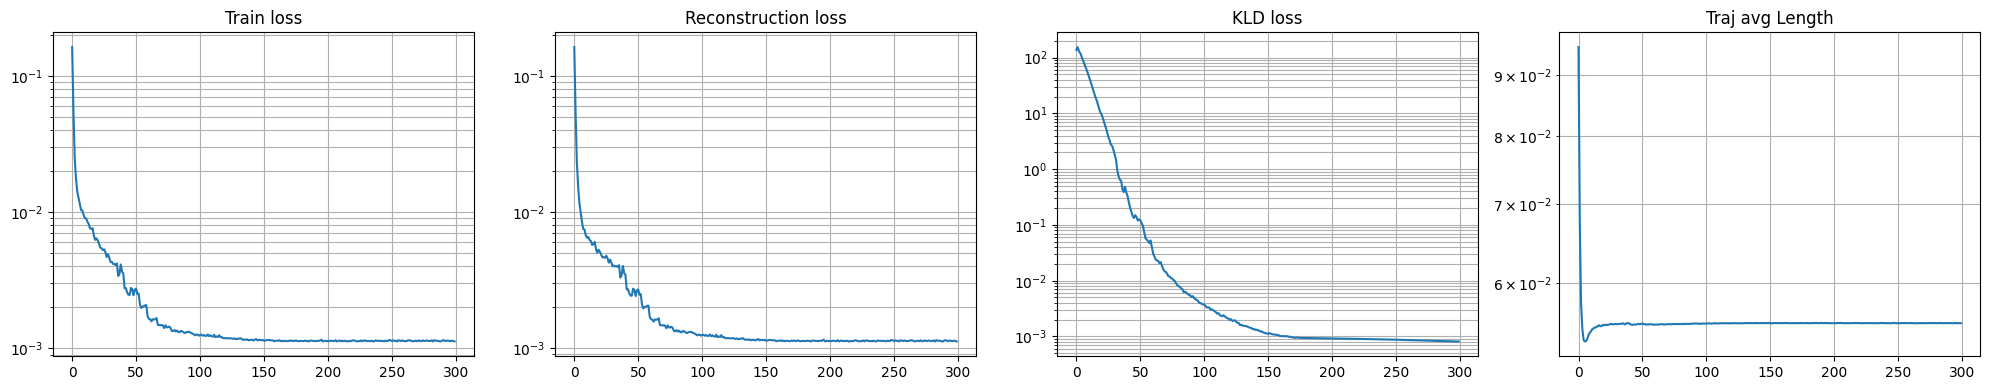

In [11]:
fig = plt.figure(figsize=(20, 4))
ax = plt.subplot(141)
ax.plot(avg_loss)
ax.set_title("Train loss")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(142)
ax .plot(avg_rec_loss)
ax.set_title("Reconstruction loss")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(143)
ax.plot(avg_q_loss)
ax.set_title("KLD loss")
ax.set_yscale('log')
ax.grid(which="both")

ax = plt.subplot(144)
ax.plot(avg_len)
ax.set_title("Traj avg Length")
ax.set_yscale('log')
ax.grid(which="both")

plt.tight_layout()
plt.show()

In [12]:
# Ground Truth
multiviz_trajs(x_trajs[:3], y_trajs[:3], z_trajs[:3], nrows=1, ncols=3, num_agents=num_agent, height=400, width=1_600)

In [13]:
# Reconstructed
npx_trajs = px_trajs.detach().cpu().numpy()
npy_trajs = py_trajs.detach().cpu().numpy()
npz_trajs = pz_trajs.detach().cpu().numpy()
multiviz_trajs(npx_trajs[:3], npy_trajs[:3], npz_trajs[:3], nrows=1, ncols=3, num_agents=num_agent, height=400, width=1_600)

In [15]:
collect_data = True
centers, radiis = [], []
primal_sol, expert_data, cond_data, latent = [], [], [], []

if collect_data:
	sample_b = 10
	cv_model.qp_layer.num_batch = sample_b
	val_loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=False)

	for (x_trajs, y_trajs, z_trajs), (center, radii) in tqdm(val_loader):

		with th.no_grad():
			trajs = th.stack([x_trajs, y_trajs, z_trajs], dim=-3).to(device)
			x_init, y_init, z_init = trajs[:, 0, :, 0], trajs[:, 1, :, 0], trajs[:, 2, :, 0]
			x_fin, y_fin, z_fin = trajs[:, 0, :, -1], trajs[:, 1, :, -1], trajs[:, 2, :, -1]
			
			state = th.cat([
				trajs[..., :1], th.zeros(1, 3, num_agent, 2, device=device), 
				trajs[..., -1:], th.zeros(1, 3, num_agent, 2, device=device)
			], dim=-1) 
			conditions = th.stack([trajs[..., 0], trajs[..., -1]], dim=-1)

			latent = th.randn((sample_b, lheight * lwidth * zdim), device=device)
			
			rec_sol = cv_model.decode(
				latent, conditions.repeat_interleave(sample_b, 0),
				x_init.repeat_interleave(sample_b, 0), y_init.repeat_interleave(sample_b, 0), z_init.repeat_interleave(sample_b, 0), 
				x_fin.repeat_interleave(sample_b, 0), y_fin.repeat_interleave(sample_b, 0), z_fin.repeat_interleave(sample_b, 0)
			)
			rec_trajs = rec_sol @ P.mT
			rec_trajs = rec_trajs.cpu().numpy()
			px_trajs, py_trajs, pz_trajs = rec_trajs[:, 0, :, :], rec_trajs[:, 1, :, :], rec_trajs[:, 2, :, :]

		primal_sol.append(rec_sol.detach().cpu())
		expert_data.append(trajs.detach().cpu())
		cond_data.append(state.repeat_interleave(sample_b, 0).detach().cpu())
		centers.append(center.repeat_interleave(sample_b, 0).detach().cpu())
		radiis.append(radii.repeat_interleave(sample_b, 0).detach().cpu())

	np.savez(
		f"./resources/data/traj_data/varying_bounds_{num_agent}/multi_trajs_cv_{cv_name}_batch_{sample_b}", 
		primals=th.cat(primal_sol).detach().cpu().numpy(),
		experts=th.cat(expert_data).detach().cpu().numpy(),
		condition=th.cat(cond_data).detach().cpu().numpy(),
		centers=th.cat(centers).detach().cpu().numpy(),
		radiis=th.cat(radiis).detach().cpu().numpy(),
	)

100%|██████████| 19999/19999 [00:49<00:00, 400.72it/s]
